In [1]:
# import libraries 
import country_converter as coco
import geopandas as gpd
import imageio #Library for GIF Creation
import io
import math
import numpy as np
import openpyxl as px
import os
import pandas as pd
import zipfile

# These lines set up the plotting funstionality and formatting.
import matplotlib 
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
matplotlib.use('Agg', warn = False)
%matplotlib inline

from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure
from urllib.request import urlopen
from zipfile import ZipFile



In [2]:
# download the data source in World Bank:
fertility_data_url = "http://api.worldbank.org/v2/en/indicator/SP.DYN.TFRT.IN?downloadformat=excel"
infant_data_url = "http://api.worldbank.org/v2/en/indicator/SP.DYN.IMRT.IN?downloadformat=csv"
# infant morality rate
zip_response = urlopen(infant_data_url)
zipfile = ZipFile(io.BytesIO(zip_response.read()))
mortality_df = pd.read_csv(zipfile.open("API_SP.DYN.IMRT.IN_DS2_en_csv_v2.csv","r"), skiprows= 4)
countries_df = pd.read_csv(zipfile.open("Metadata_Country_API_SP.DYN.IMRT.IN_DS2_en_csv_v2.csv","r"))
# fertility rate
fertility_df = pd.read_excel(fertility_data_url,"Data", skiprows = 3)
# world map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world.drop(["pop_est","gdp_md_est","continent"],1)

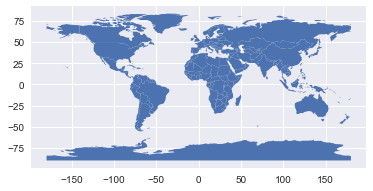

In [3]:
world.plot()

# Data Cleaning and Merging

In [4]:
# create a function for selecting years from 2011 to 2016 in each dataframe:
def selectColumns(df):
    df2 = df[["Country Name", "Country Code", "2011", "2012", "2013", "2014", "2015"]]
    return df2
mortality_df = selectColumns(mortality_df)
fertility_df = selectColumns(fertility_df)
countries_df = countries_df[["Country Code",'Region']]

In [5]:
# in order to create a world map, merge world with infant daraframe:
worldmap_df = world.merge(mortality_df, left_on="iso_a3", right_on = "Country Code")
worldmap_df = worldmap_df.drop(["Country Name","Country Code"],1)

In [6]:
worldgif_df = worldmap_df.copy()
# make infant mortality rate as 0 in Cyprus, in order to make a minimum in scale of legend
worldgif_df[worldgif_df["iso_a3"] == "CYP"]
for year in range(2011,2016):
    worldgif_df[str(year)][36] = 0.000001
# make inf mortality rate as 100 in Luxembourg, in order to set the maximum in scale of legend
for year in range(2011,2016):
    worldgif_df[str(year)][92] = 102

/Users/MandyZhang/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/MandyZhang/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [7]:
# square root each element to make visual difference bigger on the GIF map
sqrt = worldgif_df[["2011","2012","2013","2014","2015"]].apply(lambda row: np.sqrt(row))
worldgif_df[["2011","2012","2013","2014","2015"]] = sqrt

# World Map 

In [8]:
# Create animated GIF for representing changes over time
images = []
for year in range(2011,2016):
    f,ax = plt.subplots(figsize = (27,10))
    t = " Infant Mortality Rate (sqrt)"
    years = str(year) + "%s"
    title = years % t
    ax.set_title(title, fontsize = 26)
    worldgif_df.plot(alpha = 0.7, linewidth = 1, edgecolor = "k", column = str(year), legend = True,\
                cmap = "coolwarm", ax = ax)
    plt.savefig(title, dpi=200, bbox_inches='tight')
    images.append(imageio.imread(title+".png"))
    plt.close()
filename = "maps.GIF"
imageio.mimsave(filename, images, duration=0.8)


/Users/MandyZhang/anaconda/lib/python3.6/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


/Users/MandyZhang/anaconda/lib/python3.6/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


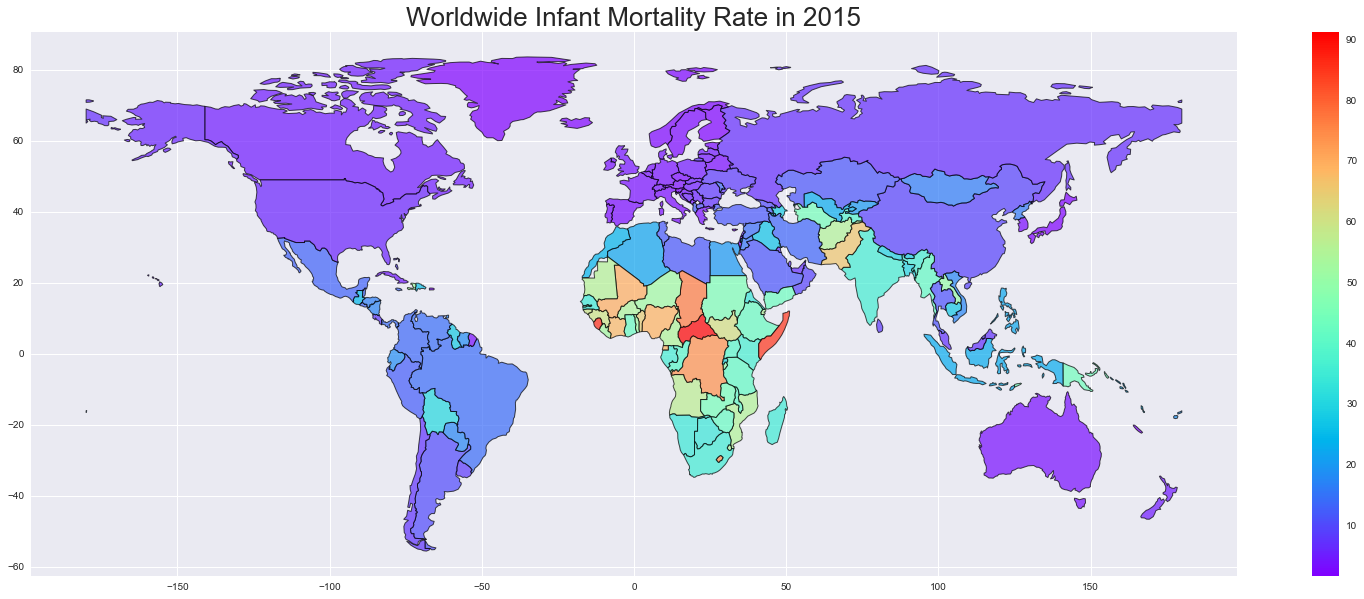

In [9]:
# world map of infant mortality rate in 2015 world wide 
f, ax = plt.subplots(1, figsize=(27,10))
ax.set_title('Worldwide Infant Mortality Rate in 2015',fontsize=26)
worldmap_df.plot(alpha = 0.7, linewidth = 1, edgecolor = 'k', column = "2015", legend = True,
              cmap = 'rainbow', ax = ax)
plt.savefig('figures/world map of infant mortality rate in 2015', dpi= 300, bbox_inches='tight')
plt.show()

In [10]:
# create a new dataframe with region information and mortality for region analysis
mortality_by_region_df = mortality_df.merge(countries_df, left_on= "Country Code", right_on="Country Code").dropna()

In [11]:
# want to find the distribution of infant moratlity rate for the mean of past 6 years
# create a function to compute the mean of 6 years in each country (each row)
def meanPast5Years(row):
    total = 0;
    for year in range(2011, 2016):
        try: 
            value = float(row[str(year)])
            if (not math.isnan(value)):
                total = total + value
        except:
            continue
    return total/5

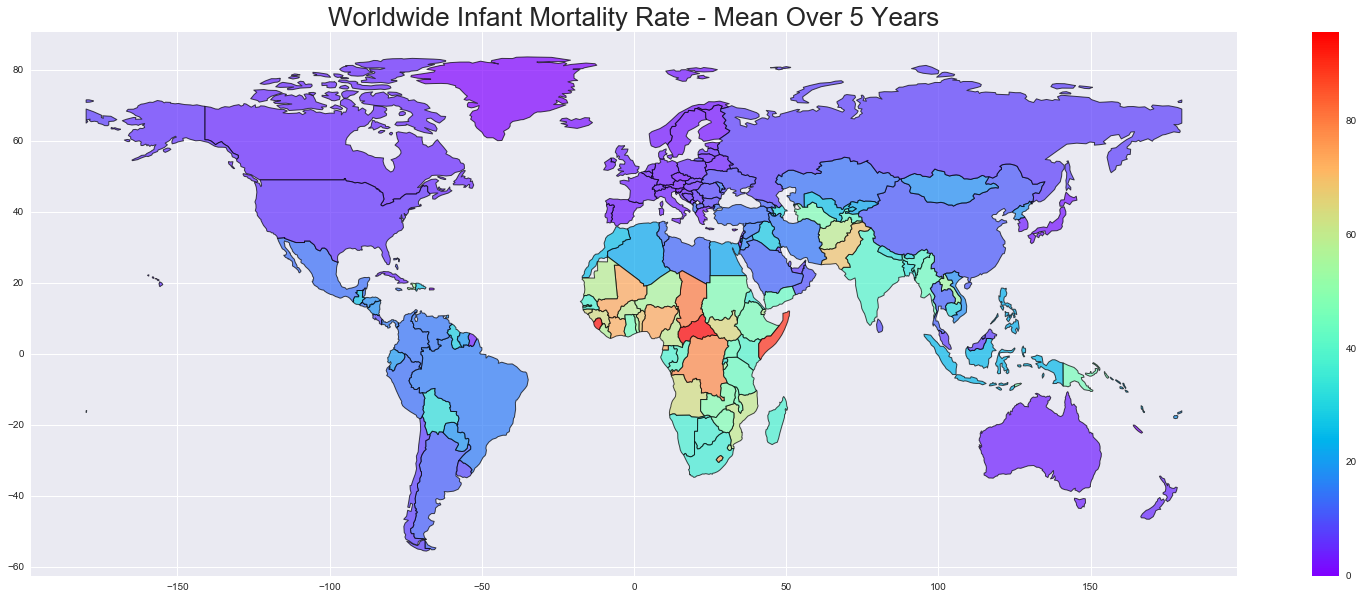

In [12]:
#add a column with mean over past five years
mean5YearsColumn = worldmap_df.apply(lambda row: meanPast5Years(row), axis=1)
mean_column_name = "Mean over five years"
worldmap_df[mean_column_name] = mean5YearsColumn

# world map of mean over six years of infant mortality
f, ax = plt.subplots(1, figsize=(27,10))
ax.set_title('Worldwide Infant Mortality Rate - Mean Over 5 Years',fontsize=26)
worldmap_df.plot(figsize = (20,10), alpha = 0.7, linewidth = 1, edgecolor = 'k', column = "Mean over five years",\
              legend = True, cmap = "rainbow", ax = ax)
plt.savefig('figures/mean over five years of infant mortality ', dpi=200, bbox_inches='tight')
plt.show()

# Distribution

In [13]:
# add a column with mean over past five years into infant_region data frame
mean5YearsColumn = mortality_by_region_df.apply(lambda row: meanPast5Years(row), axis=1)
mean_column_name = "Mean over 5 years"
mortality_by_region_df[mean_column_name] = mean5YearsColumn
mortality_by_region_df.head(4)

,Country Name,Country Code,2011,2012,2013,2014,2015,Region,Mean over 5 years
1,Afghanistan,AFG,63.3,61.0,58.8,56.8,54.9,South Asia,58.96
2,Angola,AGO,70.7,66.5,62.7,59.5,56.9,Sub-Saharan Africa,63.26
3,Albania,ALB,14.3,13.8,13.3,12.9,12.5,Europe & Central Asia,13.36
4,Andorra,AND,2.9,2.8,2.7,2.6,2.5,Europe & Central Asia,2.70


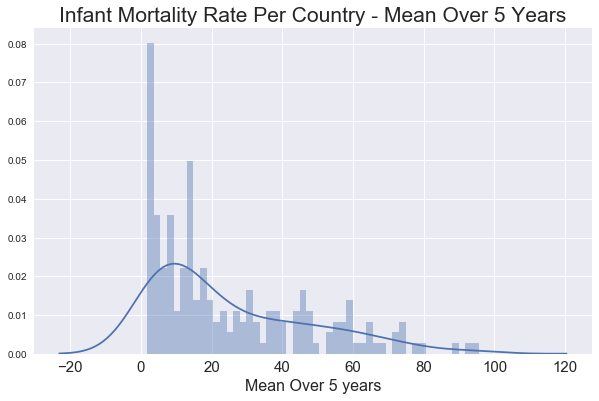

In [14]:
# distribution of mean of infant mortality over 5 years
f, ax = plt.subplots(figsize=(10, 6))
ax.set_title('Infant Mortality Rate Per Country - Mean Over 5 Years',fontsize=21)
sns.distplot(mortality_by_region_df["Mean over 5 years"],ax = ax,bins=50)
plt.xticks(fontsize = 15)
plt.xlabel("Mean Over 5 years", fontsize = 16)
plt.savefig('figures/histgram of mean', dpi=300, bbox_inches='tight')
plt.show()

In [15]:
# want to plot a swarmplot which shows infant mortality rate in each country in region
infantin5years = mortality_by_region_df.drop(["Country Name", "Country Code","Mean over 5 years"],1).dropna()
# create a new dataframe which only have three columns: years, rate, and region
x = [];y = [];z = []
years = ["2011", "2012", "2013", "2014", "2015"]
for year in years:
    for value in infantin5years[year]:
        y.append(value)
        x.append(year)
x=np.array(x)
y=np.array(y)

for i in range(0,5):
    z = z + infantin5years.Region.tolist()

swarm_df = pd.DataFrame({"x":x,
                  "y":y,
                  "Region":z})

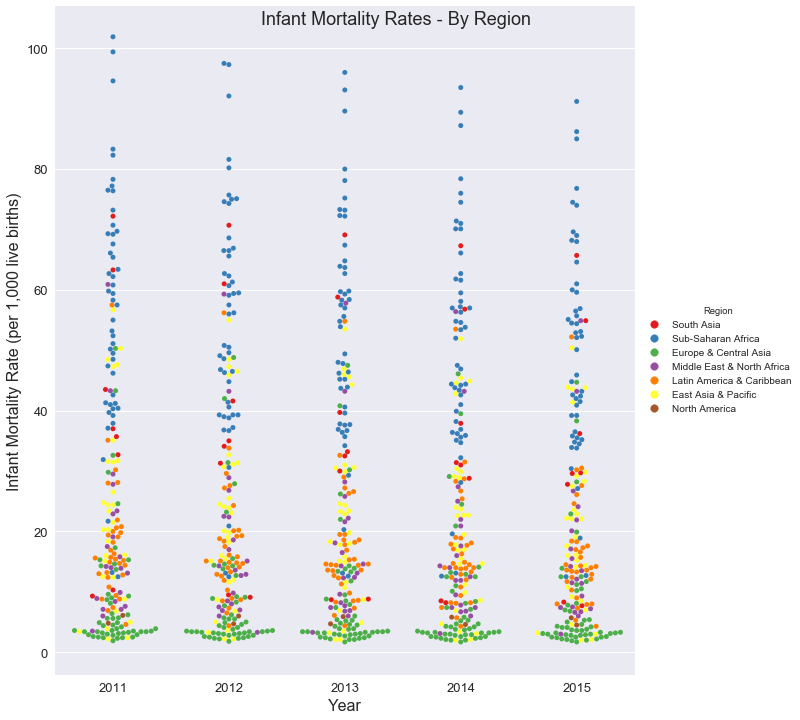

In [16]:
# use seaborn package to plot a swarmplot
g = sns.factorplot(x = "x", y = "y", hue = "Region", data = swarm_df, kind = "swarm",palette = "Set1",size = 10, aspect=0.9)
g.fig.suptitle('Infant Mortality Rates - By Region', fontsize = 18) 
plt.ylabel('Infant Mortality Rate (per 1,000 live births)', fontsize = 16)
plt.xlabel('Year', fontsize = 16)
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)
plt.savefig('figures/Infant Mortality Rate (per 1,000 live births)', dpi = 300, bbox_inches='tight')
plt.show()

In [17]:
# Number of countries in each region
mortality_by_region_df.groupby("Region").count().iloc[:,1]

Region
East Asia & Pacific           30
Europe & Central Asia         51
Latin America & Caribbean     33
Middle East & North Africa    21
North America                  2
South Asia                     8
Sub-Saharan Africa            48
Name: Country Code, dtype: int64

# Histogram of mean in each region

In [18]:
# create a dictionary which keys are regions and values are mortality rate of corresponding countries
regions = mortality_by_region_df["Region"].unique()
region_means = {}
for region in regions:
    region_means[region] = \
    mortality_by_region_df.loc[mortality_by_region_df["Region"] == region]["Mean over 5 years"].values    

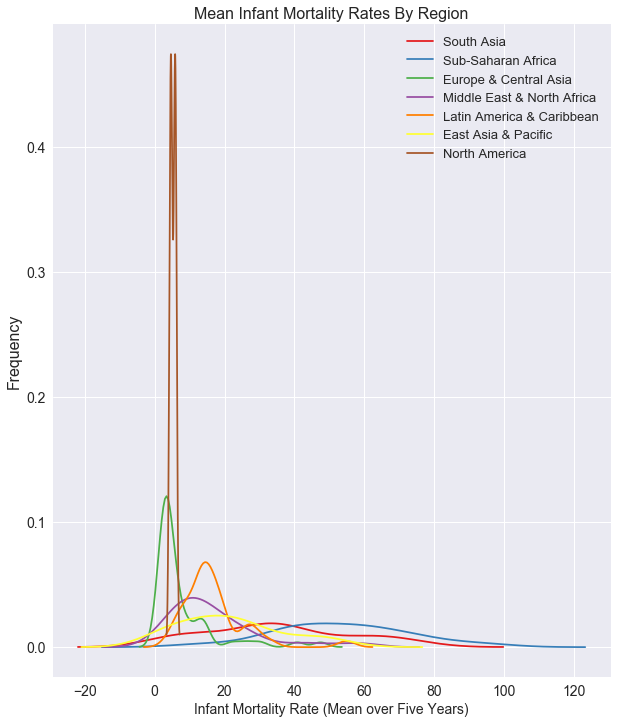

In [19]:
# histogram of each region mortality rate
fig, ax = plt.subplots(figsize=(10, 12))
i=0
for name in regions:
    g = sns.distplot(region_means[name], ax=ax, kde=True, bins = 10,label = name,hist = False,\
                     color = sns.color_palette("Set1", 7)[i]).set_title("Mean Infant Mortality Rates By Region", fontsize = 16)
    i=i+1
plt.xlabel('Infant Mortality Rate (Mean over Five Years)', fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.ylabel('Frequency', fontsize = 16)
plt.legend(fontsize = 13)
plt.savefig('figures/Histogram of mean in each region)', dpi= 300, bbox_inches='tight')
plt.show()

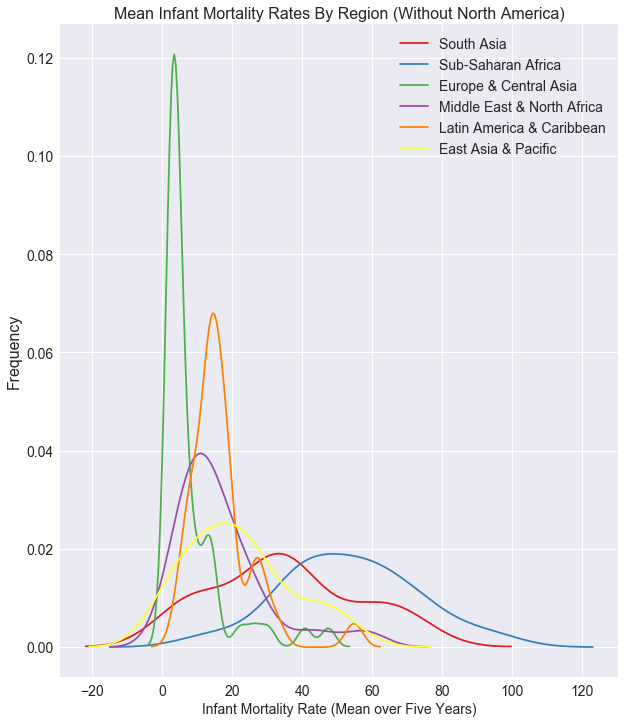

In [20]:
# plot histograms without North America region:
# drop key of North America, to get a better visual of the other regions. 
region_means.pop("North America")
regions = np.delete(regions, np.where(regions == "North America"))
# histogram of each region mortality rate
fig, ax = plt.subplots(figsize=(10, 12))
i=0
for name in regions:
    g = sns.distplot(region_means[name], ax=ax, kde=True, bins = 10,label = name,hist = False,\
                     color = sns.color_palette("Set1", 7)[i]).set_title("Mean Infant Mortality Rates By Region (Without North America)", fontsize = 16)
    i=i+1
plt.xlabel('Infant Mortality Rate (Mean over Five Years)', fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.legend(fontsize = 14)
plt.ylabel('Frequency', fontsize = 16)
plt.savefig('figures/Histogram of mean in each region 2)', dpi= 300, bbox_inches='tight')
plt.show()

# Barplot 

In [21]:
lowest_df = mortality_by_region_df.sort_values("Mean over 5 years").head(15)
highest_df = mortality_by_region_df.sort_values("Mean over 5 years", ascending= False).head(15)

In [22]:
#helper function for creating color mapping and legends
def BuildColorsAndLegends(regions):
    values, indicies = pd.factorize(regions)
    colors = pd.Series(values).map(lambda x: sns.color_palette()[x])
    labels = []
    for i in range(0, len(indicies)):
        color = sns.color_palette()[i]
        region = indicies[i]
        labels.append(mpatches.Patch(color=color, label=region))
    return colors, labels

/Users/MandyZhang/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


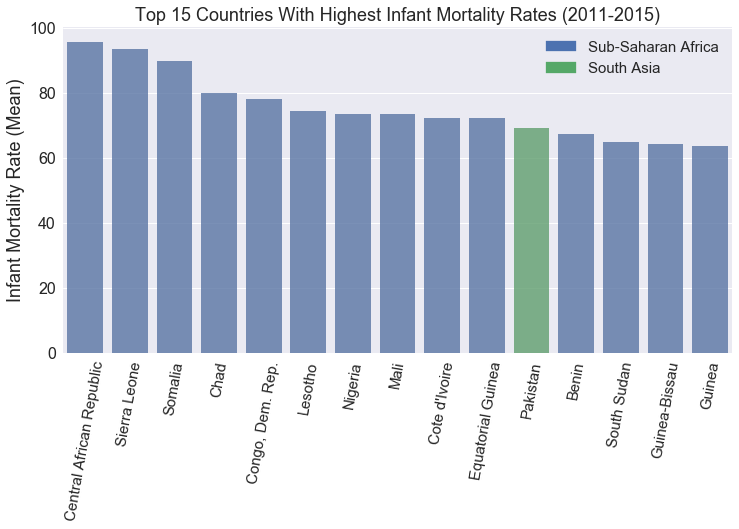

In [23]:
#Create Bar Plot For the Top 15 Countries with the Highest Mortality Rate
fig, ax = plt.subplots()
fig.set_size_inches(12, 6)
colors, labels = BuildColorsAndLegends(highest_df["Region"])
ax = sns.barplot(x="Country Name", y="Mean over 5 years", data=highest_df, palette=colors, alpha = 0.8 )
plt.title("Top 15 Countries With Highest Infant Mortality Rates (2011-2015)", fontsize = 18)
plt.xlabel('')
plt.legend(handles=labels, fontsize=15)
plt.ylabel("Infant Mortality Rate (Mean)", fontsize = 18)
plt.xticks(rotation=80,fontsize = 15)
plt.yticks(fontsize = 16)
plt.savefig('figures/Barplot of top 15 highest countries(mean))', dpi=300, bbox_inches='tight')
plt.show()

/Users/MandyZhang/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


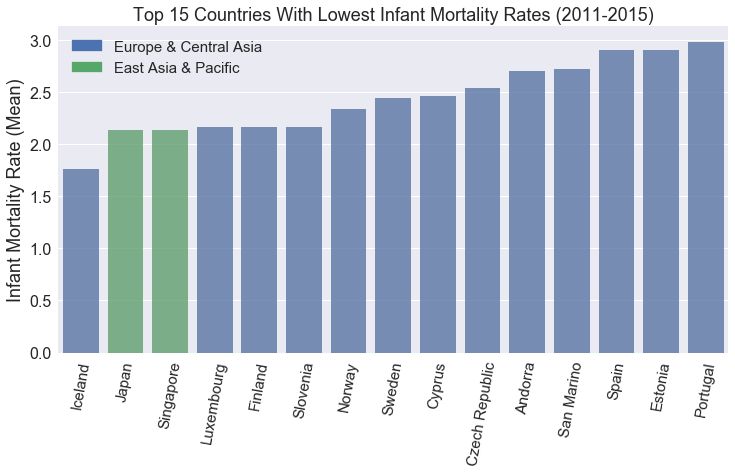

In [24]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 6)
colors, labels = BuildColorsAndLegends(lowest_df["Region"])
ax = sns.barplot(x="Country Name", y="Mean over 5 years", data=lowest_df, palette=colors, alpha=0.8)
plt.title('Top 15 Countries With Lowest Infant Mortality Rates (2011-2015)', fontsize = 18)
plt.xlabel('')
plt.legend(handles=labels, fontsize=15, loc="upper left")
plt.ylabel("Infant Mortality Rate (Mean)", fontsize = 18)
plt.xticks(rotation=80,fontsize = 15)
plt.yticks(fontsize = 16)
plt.savefig('figures/Barplot of top lowest 15 countries(mean))', dpi= 300, bbox_inches='tight')
plt.show()

# Stacked barplot

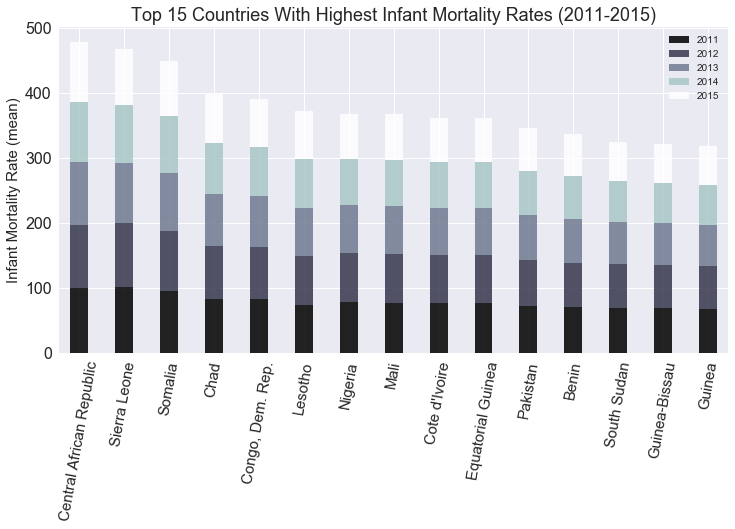

In [25]:
top15 = highest_df.drop(["Region","Mean over 5 years","Country Code"],1).set_index("Country Name")
fig, ax = plt.subplots(figsize=(12, 6))
top15.plot(kind = "bar", stacked = True, sort_columns = True, ax=ax,alpha = 0.86, cmap = "bone",width=0.4)
plt.title("Top 15 Countries With Highest Infant Mortality Rates (2011-2015)", fontsize = 18)
plt.xlabel('')
plt.ylabel("Infant Mortality Rate (mean)", fontsize = 15)
plt.xticks(rotation=80,fontsize = 15)
plt.yticks(fontsize = 16)
plt.savefig('figures/stacked barplot Top 15 Highest Infant Mortality Rate Countries', dpi = 300, bbox_inches='tight')
plt.show()

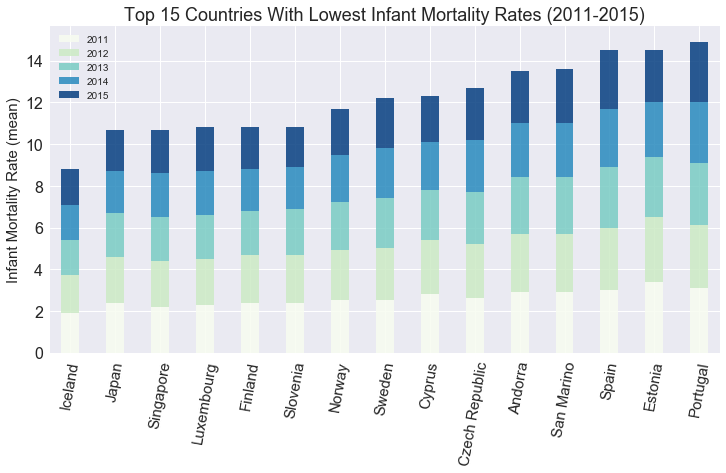

In [26]:
low15 = lowest_df.drop(["Region","Mean over 5 years","Country Code"],1).set_index("Country Name")
fig, ax = plt.subplots(figsize=(12, 6))
low15.plot(kind = "bar", stacked = True, sort_columns = True, ax=ax,alpha = 0.86,cmap = "GnBu",width=0.4)
plt.title('Top 15 Countries With Lowest Infant Mortality Rates (2011-2015)', fontsize = 18)
plt.xlabel('')
plt.ylabel("Infant Mortality Rate (mean)", fontsize = 15)
plt.xticks(rotation=80,fontsize = 15)
plt.yticks(fontsize = 16)
plt.savefig('figures/stacked barplot Top 15 lowest Infant Mortality Rate Countries', dpi= 300, bbox_inches='tight')
plt.show()

# Biggest changes during 5 years:

In [27]:
# compute the total percent of change in each country during 5 years
changes = (mortality_by_region_df["2015"]-mortality_by_region_df["2011"])/mortality_by_region_df["2011"]*100
mortality_by_region_df["changes"] = changes
mortality_by_region_df["abs_changes"] = abs(changes)
biggestchanges = mortality_by_region_df.sort_values("abs_changes", ascending=False).head(15)
smallestchange = mortality_by_region_df.sort_values("abs_changes").head(15)

/Users/MandyZhang/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


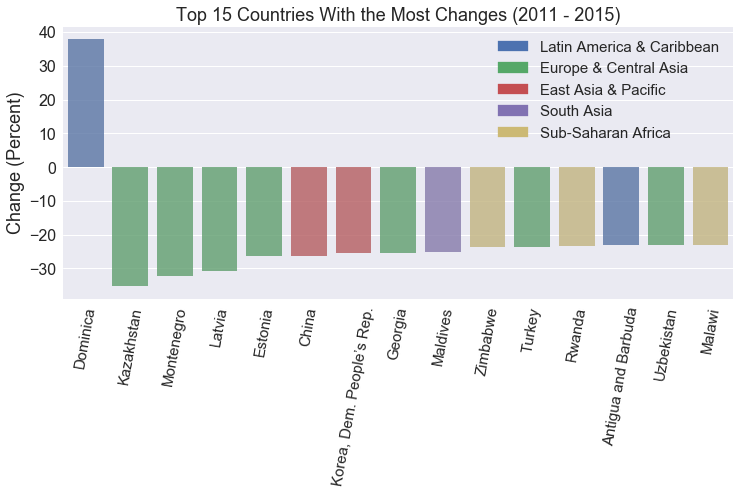

In [28]:
# barplot of Top 15 countris biggest Total Change (absolute) Over Past Five Years (Percent) 2011-2015
fig, ax = plt.subplots()
fig.set_size_inches(12, 5)
colors, labels = BuildColorsAndLegends(biggestchanges.Region)
ax = sns.barplot(x = "Country Name", y = "changes", data = biggestchanges, palette=colors, alpha = 0.8)
plt.title('Top 15 Countries With the Most Changes (2011 - 2015)', fontsize = 18)
plt.xlabel('')
plt.legend(handles=labels, fontsize=15, loc="upper right")
plt.ylabel("Change (Percent)", fontsize = 18)
plt.xticks(rotation=80,fontsize = 15)
plt.yticks(fontsize = 16)
plt.savefig('figures/biggest total change', dpi = 300, bbox_inches='tight')
plt.show()

/Users/MandyZhang/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


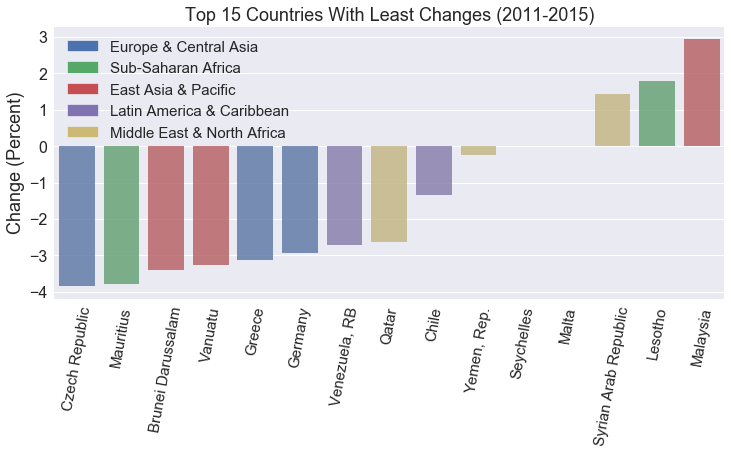

In [29]:
# bar plot of Top 15 countris least Total Change (absolute) Over Past Five Years (Percent) 2011-2015
smallestchange = smallestchange.sort_values("changes")
colors, labels = BuildColorsAndLegends(smallestchange.Region)
fig, ax = plt.subplots()
fig.set_size_inches(12, 5)
ax = sns.barplot(x = "Country Name", y = "changes", data = smallestchange, palette=colors, alpha = 0.8)
plt.title('Top 15 Countries With Least Changes (2011-2015)', fontsize = 18)
plt.xlabel('')
plt.legend(handles=labels, fontsize=15, loc="upper left")
plt.ylabel("Change (Percent)", fontsize = 18)
plt.xticks(rotation=80,fontsize = 15)
plt.yticks(fontsize = 16)
plt.savefig('figures/smallest total change', dpi = 300, bbox_inches='tight')
plt.show()

# World Map of Percent Change Over Last Five Years

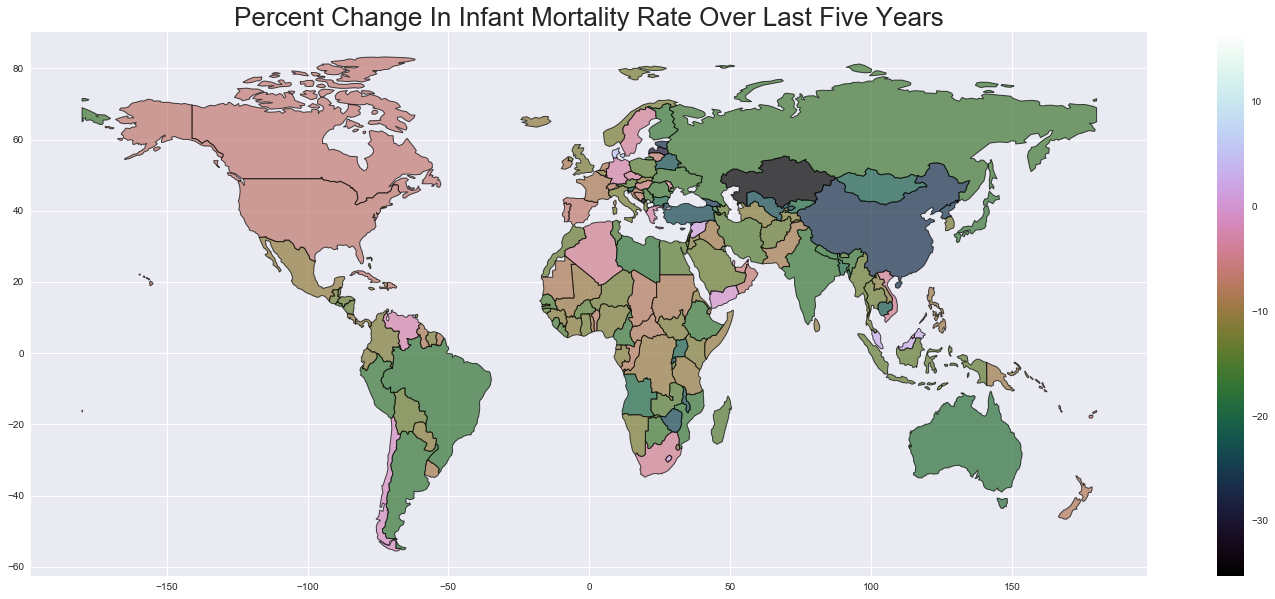

In [30]:
# world map of percent of change in five years of infnat mortality
worldmap_change = world.merge(mortality_by_region_df, left_on = "iso_a3", right_on = "Country Code")
f, ax = plt.subplots(1, figsize=(25,10))
ax.set_title('Percent Change In Infant Mortality Rate Over Last Five Years',fontsize=26)
worldmap_change.plot(alpha = 0.7, linewidth = 1, edgecolor = 'k', column = "changes",\
              legend = True, cmap = 'cubehelix', ax =ax)
plt.savefig('figures/percent of change in five years', dpi=300, bbox_inches='tight')
plt.show()

# Fertility Rate

In [31]:
fertility_df = pd.read_excel(fertility_data_url,"Data", skiprows = 3)
fertility_df = selectColumns(fertility_df)
fertility_df = fertility_df.dropna()

In [32]:
# merge fertility and infant with region information
fertility_mortality_df = fertility_df.merge(mortality_by_region_df, left_on="Country Code", right_on="Country Code")
# create a new geo-panda dataframe with only fertility information
f_map = worldmap_df.merge(fertility_mortality_df, left_on = "iso_a3", right_on = "Country Code")
worldgif2 = f_map.copy()
worldgif2 = worldgif2.iloc[:, [0,1,2,11,12,13,14,15]]
worldgif2.columns = ["country", "code", "geometry", "2011","2012","2013","2014","2015"]

In [33]:
# make infant mortality rate as 0 in Cyprus, in order to make a minimum in scale of legend
worldgif2[worldgif2["code"] == "CYP"]
for year in range(2011,2016):
    worldgif2[str(year)][36] = 1.1
# make inf mortality rate as 100 in Luxembourg, in order to set the maximum in scale of legend
for year in range(2011,2016):
    worldgif2[str(year)][92] = 7.5

/Users/MandyZhang/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [34]:
# square each element to make difference bigger on the GIF map
sqrt = worldgif2[["2011","2012","2013","2014","2015"]].apply(lambda row: np.sqrt(row))
worldgif2[["2011","2012","2013","2014","2015"]] = sqrt

In [35]:
# Make a GIF
images = []
for year in range(2011,2016):
    f,ax = plt.subplots(figsize = (27,10))
    t = " Fertility Rate (sqrt)"
    years = str(year) + "%s"
    title = years % t
    ax.set_title(title, fontsize = 26)
    worldgif2.plot(alpha = 0.7, linewidth = 1, edgecolor = "k", column = str(year), legend = True,\
                cmap = "coolwarm", ax = ax)
    plt.savefig(title, dpi=200, bbox_inches='tight')
    images.append(imageio.imread(title+".png"))
    plt.close()
filename = "fertility_maps.GIF"
imageio.mimsave(filename, images, duration=0.8)

# Correlation Analysis

In [37]:
# want to create a data frame with only correlation value, country names, code and region
# setup enmpy lists
top = 0;b1 = 0;b2 = 0;r = []
country = [];Region = [];Code = []
# use for loop to get four lists of country, Code, Region and r
for i in range(fertility_mortality_df.shape[0]):
    infant = fertility_mortality_df.iloc[i][2:7]
    fertility = fertility_mortality_df.iloc[i][8:13]
    region = fertility_mortality_df.iloc[i][13]
    name = fertility_mortality_df.iloc[i][0]
    code = fertility_mortality_df.iloc[i][1]
    
    # copmuting the correlation:
    for j in range(len(infant)):
        top = (infant[j] - infant.mean())*(fertility[j] - fertility.mean()) + top
        b1 = (infant[j] - infant.mean())**2 + b1
        b2 = (fertility[j] - fertility.mean())**2 + b2

    cor = top/(math.sqrt(b1)*math.sqrt(b2))
    r.append(cor)
    country.append(name)
    Code.append(code)
    Region.append(region)
# resemble as a data frame:
correlation_df = pd.DataFrame({"country": country,
                            "code": Code,
                            "region": Region,
                            "r":r})

In [38]:
#Distribution Across Regions
correlation_df.groupby("region").count().iloc[:,1]

region
East Asia & Pacific           26
Europe & Central Asia         48
Latin America & Caribbean     31
Middle East & North Africa    21
North America                  2
South Asia                     8
Sub-Saharan Africa            48
Name: country, dtype: int64

# Histogram Of Correlation Coefficients

In [39]:
# create a dictionary which keys are regions and values are correlation of corresponding countries
regions = correlation_df["region"].unique()
region_corr_map = {}
for region in regions:
    region_corr_map[region] = correlation_df.loc[correlation_df["region"] == region]["r"].values  

In [40]:
# drop key of North America. This is because only two element which doesn't have a nice distribution
region_corr_map.pop("North America")
regions = np.delete(regions, np.where(regions == "North America"))

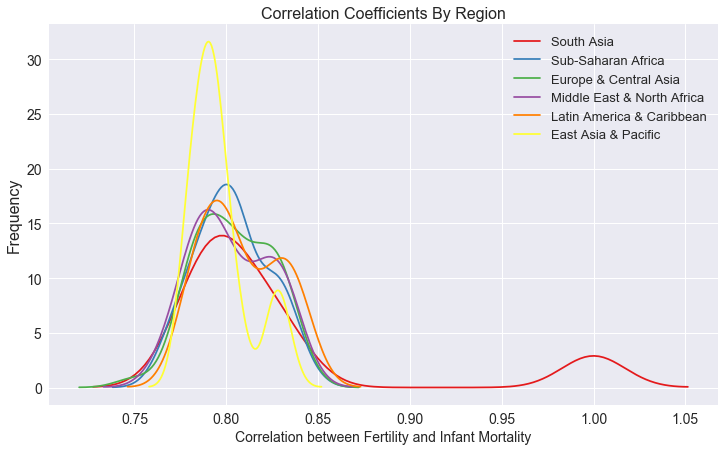

In [41]:
# histogram of correlation in each region 
fig, ax = plt.subplots(figsize=(12, 7))
i=0
for name in regions:
    g = sns.distplot(region_corr_map[name], ax=ax, kde=True, bins = 10,label = name,hist = False,\
                     color = sns.color_palette("Set1", 7)[i]).set_title("Correlation Coefficients By Region", fontsize = 16)
    i=i+1
plt.xlabel('Correlation between Fertility and Infant Mortality', fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.ylabel('Frequency', fontsize = 16)
plt.savefig('figures/Histogram of correlation', dpi=300, bbox_inches='tight')
plt.legend(fontsize = 13)
plt.show()

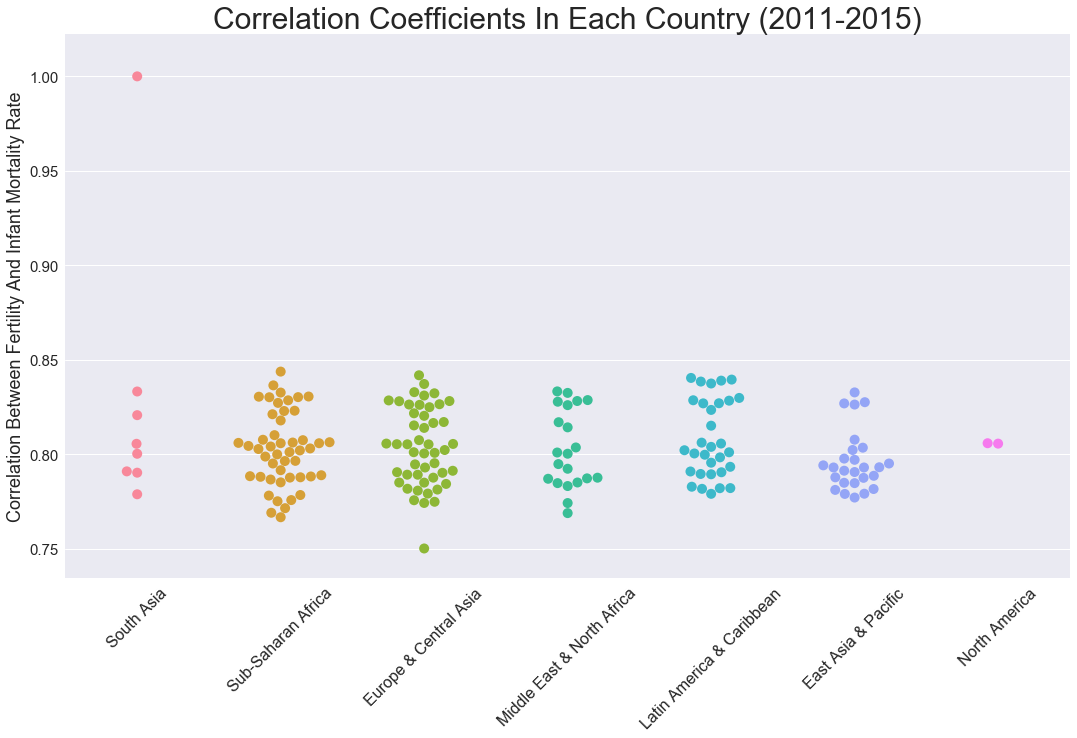

In [42]:
# plot swarmplot of correlations in each country in 7 regions
f, ax = plt.subplots(figsize=(18, 10))
g = sns.swarmplot(x="region", y="r", data=correlation_df, size = 10).\
set_title('Correlation Coefficients In Each Country (2011-2015)', fontsize = 30) 
plt.ylabel('Correlation Between Fertility And Infant Mortality Rate', fontsize = 18)
plt.xlabel('')
plt.xticks(fontsize = 16,rotation=45)
plt.yticks(fontsize = 15)
plt.savefig('figures/swarmplot of correlation', dpi= 300, bbox_inches='tight')
plt.show()

/Users/MandyZhang/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


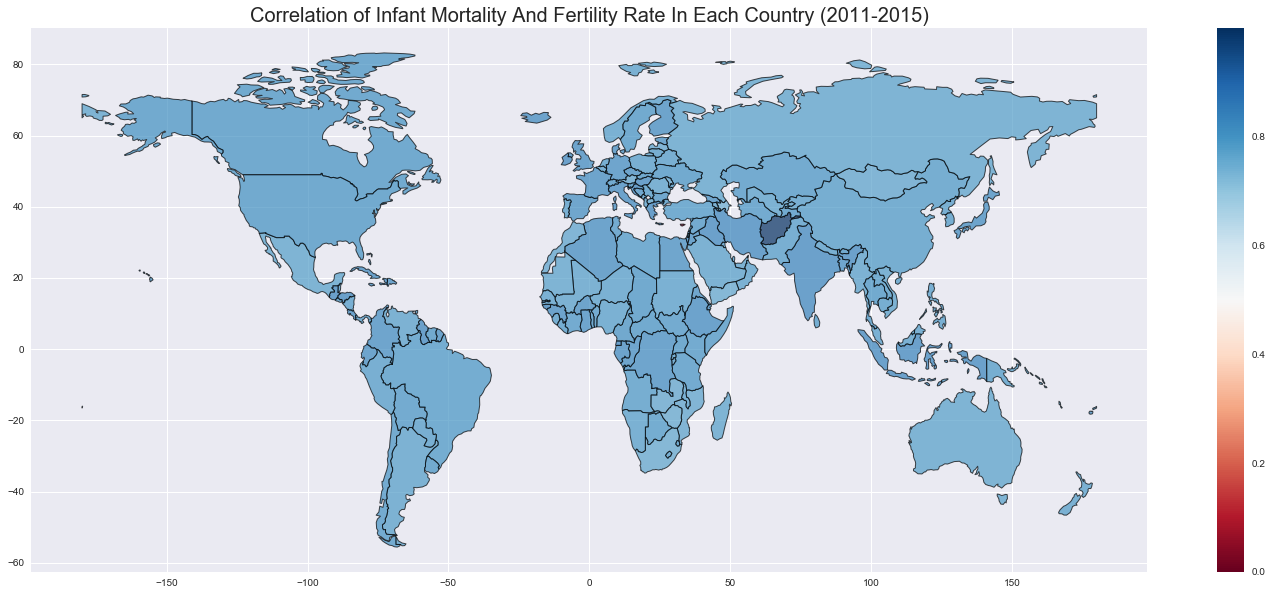

In [43]:
# world map of correlation:
correlation_map = worldmap_df.merge(correlation_df, left_on  = "iso_a3", right_on = "code")
correlation_map["r"][36] = 0
f, ax = plt.subplots(1, figsize=(25,10))
ax.set_title('Correlation of Infant Mortality And Fertility Rate In Each Country (2011-2015)', fontsize = 20)
correlation_map.plot( alpha = 0.7, linewidth = 1, edgecolor = 'k', column = "r",\
          legend = True, cmap = "RdBu", ax =ax)
plt.savefig('figures/worldmap of correlation', dpi= 300, bbox_inches='tight')
plt.show()